# CNN + MaxPool
Restructure code.
Here, make sure we can do loops of train+test using all of both files.

TO DO: pass validation data to fit().

In [73]:
from datetime import datetime
print(datetime.now())

2023-03-16 01:39:17.652350


In [74]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [75]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=128 
FILTERSIZE=16
RCELLS=32
DCELLS=64
EPOCHS=12 
EMBED_DIMEN = 4 # arbitrary hyperparameter
MINLEN=200
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
NUM_LINES = 15   # 15 to analyze all of them

Python 3.9.16
sklearn 1.2.2


In [76]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [77]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

## Data Load

In [78]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = np.power(values,2)
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = 0.0
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN \
                    and gene_id in self.gene2rci.keys():
                        allids.append( (gene_id,tran_id) )
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

## Model

In [79]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    pool_layer = GlobalMaxPooling1D()
    flat_layer = Flatten()
    dens_layer = Dense(DCELLS,activation='sigmoid')
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool_layer)
    #cnn.add(flat_layer)
    cnn.add(dens_layer)
    cnn.add(drop_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [80]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-16 01:39:19.102561
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, 4997, 4)           1028      
                                                                 
 conv1d_40 (Conv1D)          (None, 4982, 128)         8320      
                                                                 
 global_max_pooling1d_12 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_80 (Dense)            (None, 64)                8256      
                                                                 
 dropout_40 (Dropout)        (None, 64)                0         
                                                                 
 dense_81 (Dense)            (None, 1)                 65        
                          

## Training

In [81]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def set_sequences(self, allids, allseq):
        # Keep IDs and sequences in same order.
        self.all_ids = allids  # pairs of (gene_id,tran_id)
        self.all_seqs = allseq  # may be vectors of K-mers
            
    def set_rci_map(self, gene_to_rci):
        # The map is for fast lookup, not gene order.
        self.rci_map = gene_to_rci # map gene_id to RCI value
    
    def _get_X_y(self, exclude_middle=False): # to do: validation subset
        subsetX=[]
        subsetY=[]
        for t in range(len(self.all_ids)):
            gene_id,tran_id = self.all_ids[t]
            oneX            = self.all_seqs[t]
            oneY            = self.rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self):
        print(datetime.now())
        X_train,y_rci = self._get_X_y() 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        y_rci = None
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y() 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.2f%%' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [82]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-16 01:39:19.327947
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4236 sequences.
2023-03-16 01:39:25.808678

Training # 1 1
2023-03-16 01:39:25.808843
2023-03-16 01:39:25.808897
Discriminator is GMM
Means [-0.6265731768958065, 1.7687240563756081]
Variances [10.17513157  2.85097303]
Priors [0.23695039 0.76304961]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
FIT
2023-03-16 01:39:29.107512


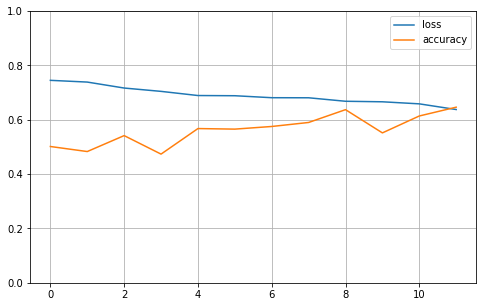


2023-03-16 01:39:50.793095

Testing # 1 1
2023-03-16 01:39:50.798003
2023-03-16 01:39:50.798550
PREDICT
2023-03-16 01:39:51.010914
Test 1:0 738:104 87.65%
Predict 1:0 534:308 63.42%
Test sizes (842, 4997) (842,)
Range of scores: 0.34181646 to 0.7550781
Score threshold 0.5


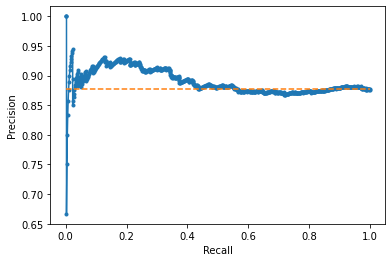

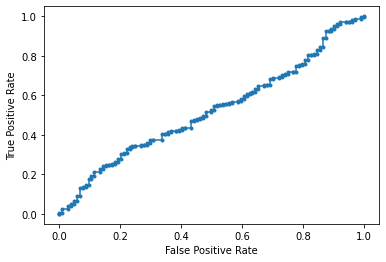

Accuracy: 59.62% Precision: 87.27% Recall: 63.14%
F1: 73.27% MCC: -0.02%
AUPRC: 88.97% AUROC: 52.32%
 accuracy [59.61995249406176]
 precision [87.26591760299625]
 recall [63.143631436314365]
 F1 [73.27044025157234]
 MCC [-0.015308675226100668]
 AUPRC [88.97091605830622]
 AUROC [52.31524911402959]
2023-03-16 01:39:51.750628

Training # 1 2
2023-03-16 01:39:51.750776
2023-03-16 01:39:51.750820
Discriminator is GMM
Means [1.9181956869302774, -0.302109113505207]
Variances [2.64117518 8.57207465]
Priors [0.66118711 0.33881289]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
FIT
2023-03-16 01:39:54.271096


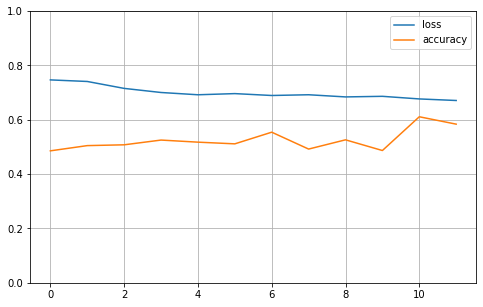


2023-03-16 01:40:15.308435

Testing # 1 2
2023-03-16 01:40:15.308538
2023-03-16 01:40:15.308580
PREDICT
2023-03-16 01:40:15.526813
Test 1:0 728:126 85.25%
Predict 1:0 614:240 71.90%
Test sizes (854, 4997) (854,)
Range of scores: 0.42932963 to 0.6630656
Score threshold 0.5


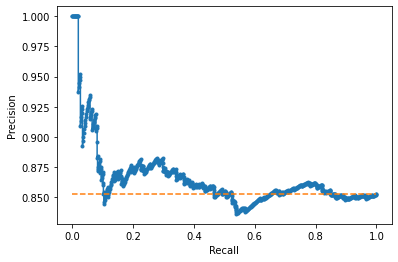

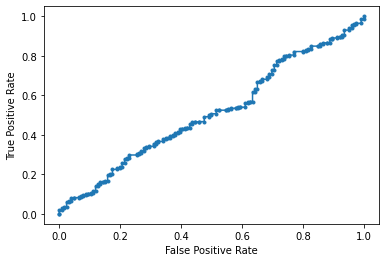

Accuracy: 66.04% Precision: 85.67% Recall: 72.25%
F1: 78.39% MCC: 0.02%
AUPRC: 86.51% AUROC: 51.24%
 accuracy [66.04215456674473]
 precision [85.66775244299674]
 recall [72.25274725274726]
 F1 [78.39046199701937]
 MCC [0.019025862509515865]
 AUPRC [86.50880488793817]
 AUROC [51.23680882609454]
2023-03-16 01:40:16.172432

Training # 1 3
2023-03-16 01:40:16.173137
2023-03-16 01:40:16.173188
Discriminator is GMM
Means [-0.06451606218090697, 2.1354710069417213]
Variances [6.39135988 2.33843511]
Priors [0.41224991 0.58775009]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
FIT
2023-03-16 01:40:18.471792


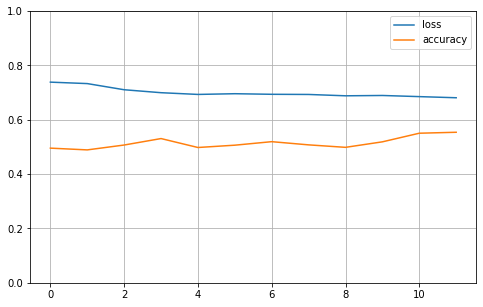


2023-03-16 01:40:40.776057

Testing # 1 3
2023-03-16 01:40:40.776127
2023-03-16 01:40:40.776162
PREDICT
2023-03-16 01:40:41.008982
Test 1:0 581:248 70.08%
Predict 1:0 56:773  6.76%
Test sizes (829, 4997) (829,)
Range of scores: 0.38959917 to 0.5276822
Score threshold 0.5


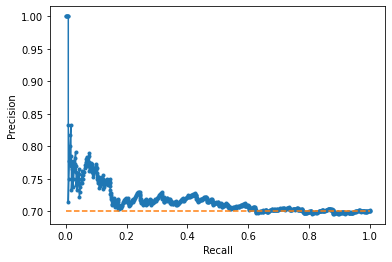

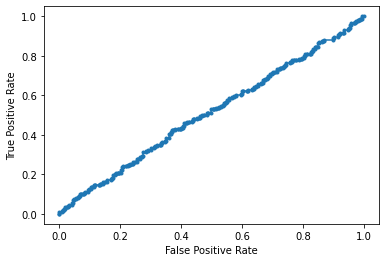

Accuracy: 33.78% Precision: 78.57% Recall: 7.57%
F1: 13.81% MCC: 0.05%
AUPRC: 71.79% AUROC: 51.33%
 accuracy [33.775633293124244]
 precision [78.57142857142857]
 recall [7.573149741824441]
 F1 [13.814756671899527]
 MCC [0.0498882827275224]
 AUPRC [71.78996813990875]
 AUROC [51.326966853589475]
2023-03-16 01:40:41.781103

Training # 1 4
2023-03-16 01:40:41.781231
2023-03-16 01:40:41.781276
Discriminator is GMM
Means [-0.27496887389276037, 1.9368832937938523]
Variances [8.43673025 2.60594976]
Priors [0.32913589 0.67086411]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
FIT
2023-03-16 01:40:44.201740


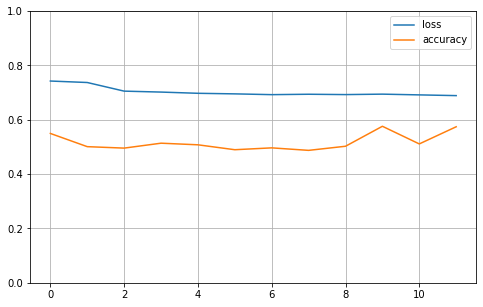


2023-03-16 01:41:05.365639

Testing # 1 4
2023-03-16 01:41:05.367459
2023-03-16 01:41:05.367812
PREDICT
2023-03-16 01:41:05.780318
Test 1:0 709:153 82.25%
Predict 1:0 2:860  0.23%
Test sizes (862, 4997) (862,)
Range of scores: 0.46191764 to 0.50300825
Score threshold 0.5


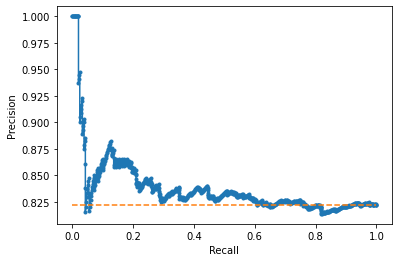

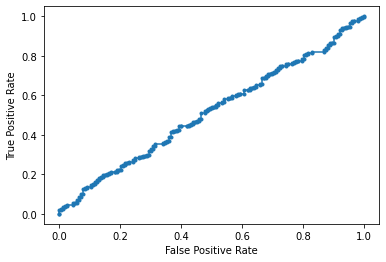

Accuracy: 17.98% Precision: 100.00% Recall: 0.28%
F1: 0.56% MCC: 0.02%
AUPRC: 83.80% AUROC: 51.52%
 accuracy [17.98143851508121]
 precision [100.0]
 recall [0.2820874471086037]
 F1 [0.5625879043600562]
 MCC [0.022402081352538912]
 AUPRC [83.79935619609662]
 AUROC [51.522442545424376]
2023-03-16 01:41:06.708433

Training # 1 5
2023-03-16 01:41:06.708533
2023-03-16 01:41:06.708571
Discriminator is GMM
Means [-0.2639088514137343, 2.0251882414569384]
Variances [7.6624549  2.54334608]
Priors [0.3612769 0.6387231]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
FIT
2023-03-16 01:41:08.904555


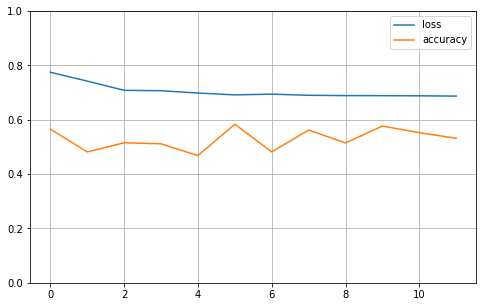


2023-03-16 01:41:29.232262

Testing # 1 5
2023-03-16 01:41:29.232332
2023-03-16 01:41:29.232364
PREDICT
2023-03-16 01:41:29.454245
Test 1:0 687:162 80.92%
Predict 1:0 144:705 16.96%
Test sizes (849, 4997) (849,)
Range of scores: 0.44524708 to 0.55806875
Score threshold 0.5


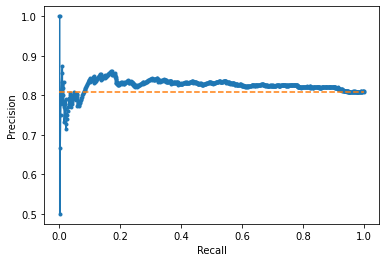

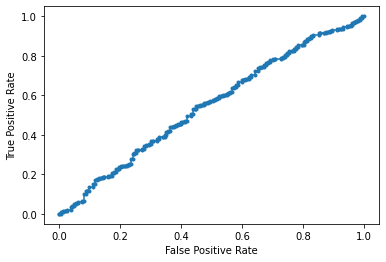

Accuracy: 31.10% Precision: 85.42% Recall: 17.90%
F1: 29.60% MCC: 0.05%
AUPRC: 82.51% AUROC: 54.79%
 accuracy [31.09540636042403]
 precision [85.41666666666666]
 recall [17.903930131004365]
 F1 [29.602888086642597]
 MCC [0.05173352120262477]
 AUPRC [82.50725675310497]
 AUROC [54.789117113231626]
2023-03-16 01:41:30.316443

Training # 2 1
2023-03-16 01:41:30.319399
2023-03-16 01:41:30.319817
Discriminator is GMM
Means [-0.26507185127943605, 2.0462126249228514]
Variances [7.25911297 2.44828978]
Priors [0.35462721 0.64537279]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
FIT
2023-03-16 01:41:34.528672


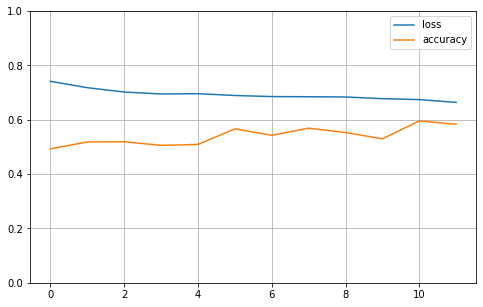


2023-03-16 01:41:56.148737

Testing # 2 1
2023-03-16 01:41:56.148837
2023-03-16 01:41:56.148879
PREDICT
2023-03-16 01:41:56.379365
Test 1:0 655:202 76.43%
Predict 1:0 625:232 72.93%
Test sizes (857, 4997) (857,)
Range of scores: 0.39755064 to 0.7055505
Score threshold 0.5


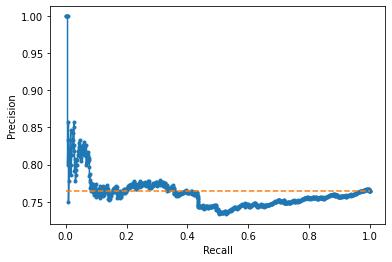

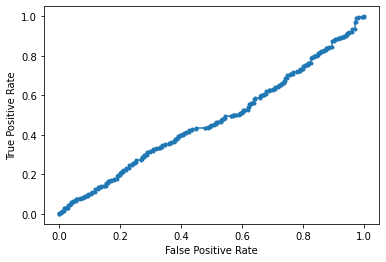

Accuracy: 60.33% Precision: 75.20% Recall: 71.76%
F1: 73.44% MCC: -0.05%
AUPRC: 76.23% AUROC: 47.34%
 accuracy [60.3267211201867]
 precision [75.2]
 recall [71.7557251908397]
 F1 [73.43750000000001]
 MCC [-0.04754178059687996]
 AUPRC [76.2318996162967]
 AUROC [47.34033708714383]
2023-03-16 01:41:57.310886

Training # 2 2
2023-03-16 01:41:57.311040
2023-03-16 01:41:57.311087
Discriminator is GMM
Means [-0.24432472546246417, 1.8742135411819374]
Variances [8.59397877 2.66589318]
Priors [0.32652714 0.67347286]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
FIT
2023-03-16 01:42:01.654432


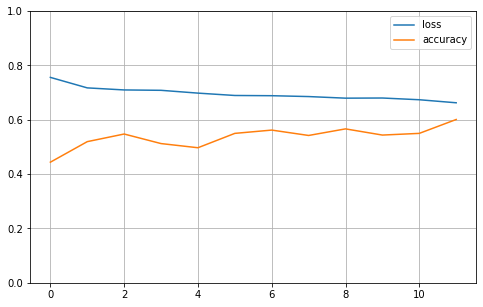


2023-03-16 01:42:23.291347

Testing # 2 2
2023-03-16 01:42:23.293345
2023-03-16 01:42:23.294144
PREDICT
2023-03-16 01:42:23.688348
Test 1:0 708:141 83.39%
Predict 1:0 384:465 45.23%
Test sizes (849, 4997) (849,)
Range of scores: 0.35706347 to 0.7047468
Score threshold 0.5


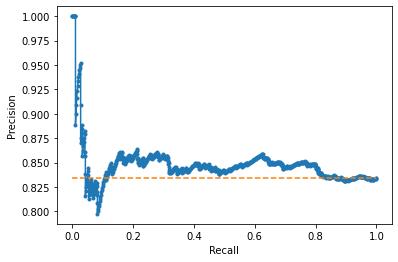

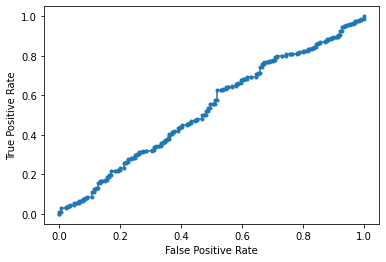

Accuracy: 47.70% Precision: 84.38% Recall: 45.76%
F1: 59.34% MCC: 0.02%
AUPRC: 84.75% AUROC: 53.28%
 accuracy [47.70318021201413]
 precision [84.375]
 recall [45.76271186440678]
 F1 [59.34065934065933]
 MCC [0.023997954943910188]
 AUPRC [84.75375387901227]
 AUROC [53.27863925952639]
2023-03-16 01:42:24.663328

Training # 2 3
2023-03-16 01:42:24.664967
2023-03-16 01:42:24.665325
Discriminator is GMM
Means [1.949621094718331, -0.2758857846112329]
Variances [2.63051931 8.45538493]
Priors [0.66625297 0.33374703]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
FIT
2023-03-16 01:42:28.389716


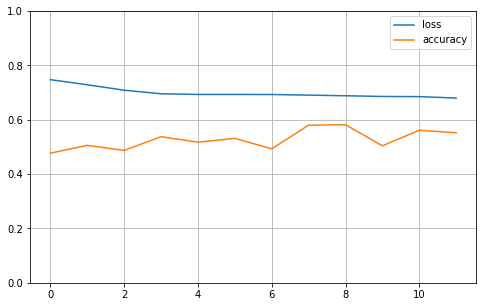


2023-03-16 01:42:50.035816

Testing # 2 3
2023-03-16 01:42:50.037520
2023-03-16 01:42:50.037872
PREDICT
2023-03-16 01:42:50.400661
Test 1:0 680:146 82.32%
Predict 1:0 783:43 94.79%
Test sizes (826, 4997) (826,)
Range of scores: 0.45214403 to 0.6928904
Score threshold 0.5


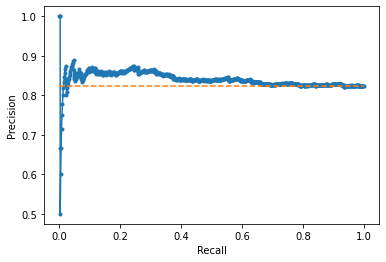

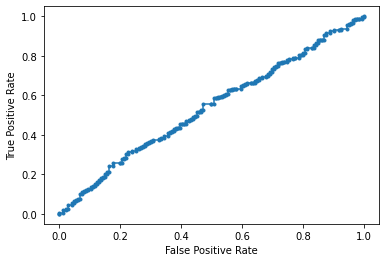

Accuracy: 79.06% Precision: 82.38% Recall: 94.85%
F1: 88.17% MCC: 0.01%
AUPRC: 84.05% AUROC: 53.78%
 accuracy [79.05569007263922]
 precision [82.37547892720306]
 recall [94.85294117647058]
 F1 [88.17498291182501]
 MCC [0.005707789481692442]
 AUPRC [84.04958337441002]
 AUROC [53.78021756647864]
2023-03-16 01:42:52.091807

Training # 2 4
2023-03-16 01:42:52.097792
2023-03-16 01:42:52.098118
Discriminator is GMM
Means [1.9217767995079464, -0.2738435424810465]
Variances [2.66801201 8.46249649]
Priors [0.66551019 0.33448981]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
FIT
2023-03-16 01:42:55.264894


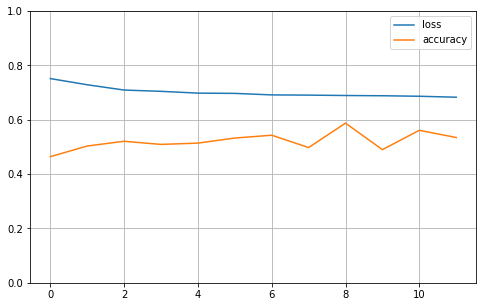


2023-03-16 01:43:17.060025

Testing # 2 4
2023-03-16 01:43:17.061390
2023-03-16 01:43:17.061755
PREDICT
2023-03-16 01:43:17.469444
Test 1:0 735:125 85.47%
Predict 1:0 443:417 51.51%
Test sizes (860, 4997) (860,)
Range of scores: 0.41699433 to 0.56155384
Score threshold 0.5


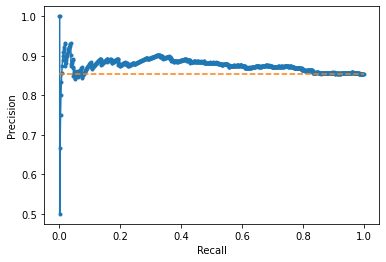

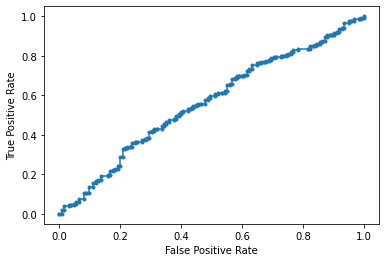

Accuracy: 53.72% Precision: 88.04% Recall: 53.06%
F1: 66.21% MCC: 0.08%
AUPRC: 87.54% AUROC: 56.36%
 accuracy [53.72093023255814]
 precision [88.03611738148985]
 recall [53.06122448979592]
 F1 [66.21392190152802]
 MCC [0.07518580840902617]
 AUPRC [87.53642808520964]
 AUROC [56.36353741496599]
2023-03-16 01:43:18.383556

Training # 2 5
2023-03-16 01:43:18.389072
2023-03-16 01:43:18.389395
Discriminator is GMM
Means [1.9768664210853615, -0.131429256815772]
Variances [2.50963714 7.66511953]
Priors [0.63132841 0.36867159]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
FIT
2023-03-16 01:43:21.867874


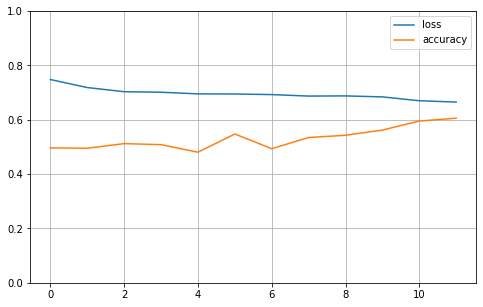


2023-03-16 01:43:41.792140

Testing # 2 5
2023-03-16 01:43:41.792280
2023-03-16 01:43:41.792345
PREDICT
2023-03-16 01:43:42.026392
Test 1:0 664:180 78.67%
Predict 1:0 272:572 32.23%
Test sizes (844, 4997) (844,)
Range of scores: 0.3663255 to 0.656805
Score threshold 0.5


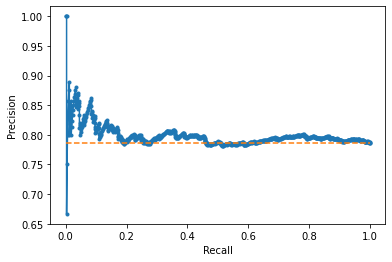

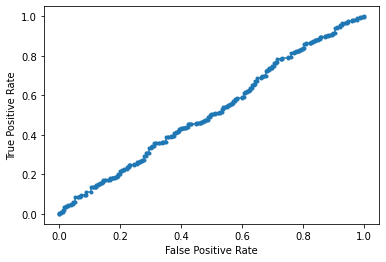

Accuracy: 41.00% Precision: 80.51% Recall: 32.98%
F1: 46.79% MCC: 0.03%
AUPRC: 79.87% AUROC: 51.92%
 accuracy [40.99526066350711]
 precision [80.51470588235294]
 recall [32.98192771084337]
 F1 [46.7948717948718]
 MCC [0.031005034575220355]
 AUPRC [79.87379064087861]
 AUROC [51.92018072289157]
2023-03-16 01:43:42.782367


In [83]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_sequence(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_sequences(train_allids,train_allseq)
        cvdo.set_rci_map(train_gene_to_rci)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model()

        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.set_sequences(test_allids,test_allseq)
        cvdo.set_rci_map(test_gene_to_rci)
        cvdo.reset_statistics()
        cvdo.test_without_training()
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [84]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 49.03% std 18.37
 precision mean 84.74% std 6.70
 recall mean 45.96% std 30.93
 F1 mean 52.96% std 29.43
 MCC mean 0.02% std 0.04
 AUPRC mean 82.60% std 5.30
 AUROC mean 52.39% std 2.43
 accuracy [[59.61995249406176], [66.04215456674473], [33.775633293124244], [17.98143851508121], [31.09540636042403], [60.3267211201867], [47.70318021201413], [79.05569007263922], [53.72093023255814], [40.99526066350711]]
 precision [[87.26591760299625], [85.66775244299674], [78.57142857142857], [100.0], [85.41666666666666], [75.2], [84.375], [82.37547892720306], [88.03611738148985], [80.51470588235294]]
 recall [[63.143631436314365], [72.25274725274726], [7.573149741824441], [0.2820874471086037], [17.903930131004365], [71.7557251908397], [45.76271186440678], [94.85294117647058], [53.06122448979592], [32.98192771084337]]
 F1 [[73.27044025157234], [78.39046199701937], [13.814756671899527], [0.5625879043600562], [29.602888086642597], [73.43750000000001], [59.34065934065933], [88.174982911825